# Kaggle - Titanic competition dataset

## Table of Contents
<ul>
<li><a href="#wrangle">Data Wrangling</a></li>
<li><a href="#visu">Visualizations</a></li>
<li><a href="#1sub">First Submission</a></li>
<li><a href="#valid">Model Validation</a></li>
<li><a href="#metrics">Metrics</a></li>
<li><a href="#newvar">Testing Different Variables</a></li>
<li><a href="#sens">Sensitivity vs. Specificity</a></li>
    <li><a href="#roc">ROC Curves</a></li>
</ul>

### Data Wrangling
<a id='wrangle'></a>

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('gender_submission.csv')

In [3]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9000,NaN,S
370,371,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,C
224,225,1,1,"Hoyt, Mr. Frederick Maxfield",male,38.0,1,0,19943,90.0000,C93,S
364,365,0,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import KFold

In [5]:
def gender_transform(x):
    if x == 'female':
        return 1
    else: 
        return 0
    
train['Gender_Bi'] = train['Sex'].map(gender_transform)
test['Gender_Bi'] = test['Sex'].map(gender_transform)

### Finding Patterns in the name

In [6]:
# Search for context aspects 

titles = ['Miss', 'Mr', 'Master', 'Dr', 'Mrs', 'Rev', 'Countess']


def find_title_in_name(x):
    for title in titles: 
        #print('Finding:', strategy)
        if re.search(title, x): 
            #print('Found:', strategy)
            return title


train['Title'] = train['Name'].map(find_title_in_name)
test['Title'] = test['Name'].map(find_title_in_name)

# Title Categorical Variable Transformation

def title_adjust(y):
    if y == 'Miss':
        return 1
    if y == 'Mr':
        return 2
    if y == 'Master': 
        return 3
    if y == 'Dr': 
        return 4
    if y == 'Mrs': 
        return 5 
    if y == 'Rev':
        return 6
    if y == 'Countess':
        return 7
    
train['Title'] = train['Title'].map(title_adjust)
test['Title'] = test['Title'].map(title_adjust)

train = train.fillna(0)

train['Title'] = train['Title'].astype(np.int64)

## Visualizations

<a id='visu'></a>

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

### Univariate Exploration

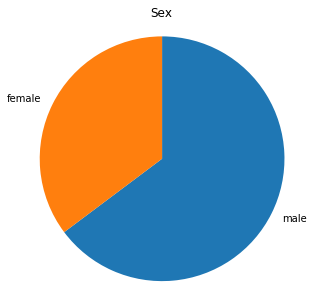

In [8]:
# Piechart Sex

plt.figure(figsize=[5,5])  

plt.title('Sex')  

def pie_sex():
    sorted_counts = train['Sex'].value_counts()
    plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False);
    plt.axis('square');

pie_sex()    

##### Fare Distribution

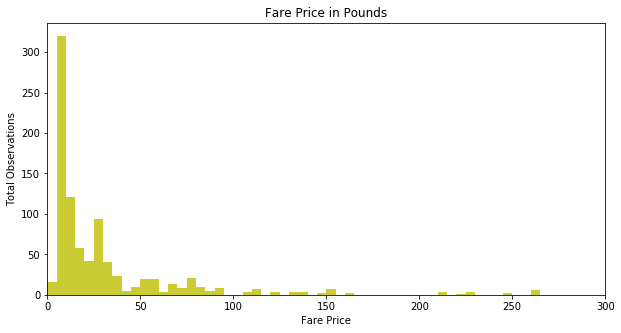

In [9]:
binsize = 5
bins = np.arange(0, train['Fare'].max()+binsize, binsize)

def graph():
    plt.hist(data = train, alpha=0.8, facecolor='y', x = 'Fare', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Fare Price in Pounds')    
plt.ylabel('Total Observations')
plt.xlabel('Fare Price')
plt.xlim([0, 300])


plt.show(graph());

##### Age Distribution

In [10]:
train.query('Age > 0 and Age < 0.5')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,0,C,0,3


In [11]:
train.query('Age == 0').count()

PassengerId    177
Survived       177
Pclass         177
Name           177
Sex            177
Age            177
SibSp          177
Parch          177
Ticket         177
Fare           177
Cabin          177
Embarked       177
Gender_Bi      177
Title          177
dtype: int64

By doing some research to find if age 0.42 is an error or a baby. I found that the age is correct and set it as the inferior limit. Passengers aged zero were removed to display the Age distribution. 

https://www.encyclopedia-titanica.org/titanic-survivor/assad-alexander-thomas-tannous.html

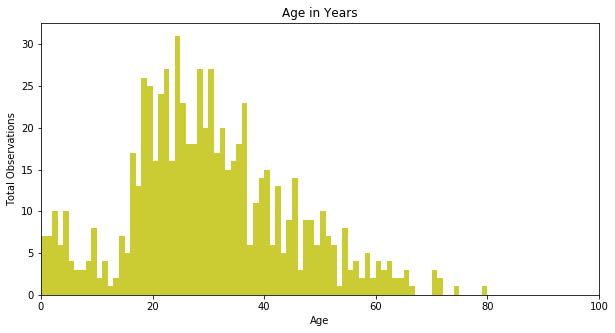

In [12]:
binsize = 1
bins = np.arange(0, train['Age'].max()+binsize, binsize)

train_age_not_zero = train.query('Age > 0.4')

def graph():
    plt.hist(data = train_age_not_zero, alpha=0.8, facecolor='y', x = 'Age', bins = bins)
    
plt.figure(figsize=[10,5])    
plt.title('Age in Years')    
plt.ylabel('Total Observations')
plt.xlabel('Age')
plt.xlim([0, 100])


plt.show(graph());

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,2


### Bivariate Exploration

In [14]:
import seaborn as sb

numeric_vars = ['Gender_Bi', 'Age', 'Pclass', 'Survived']


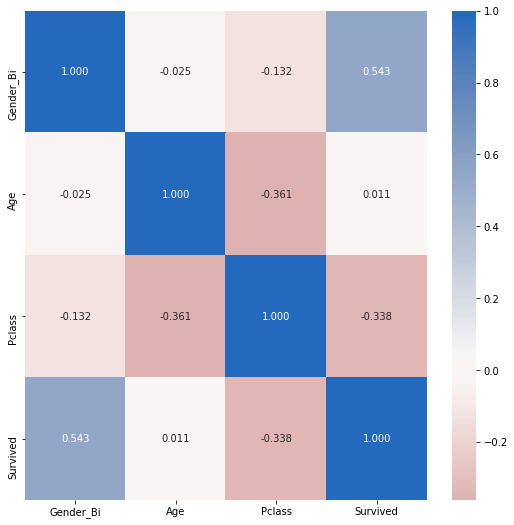

In [15]:
plt.figure(figsize=[9,9])   

def graph():
    sb.heatmap(train[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center=0)
    
graph()   

The passenger class is negatively correlated with the survival variable. This means that the higher the class, the lower are the chances of survival. For example, if a person is in the second class, it has a lower chance of survival than a person in the first class. 

## Model First Submission

Submission with variables Gender_Bi and, Fare without validation.

<a id='1sub'></a>

In [46]:
variables = ['Gender_Bi', 'Fare']

X = train[variables]
y = train['Survived']

In [47]:
X = X.fillna(-1)

In [48]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X, y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [49]:
X_prev = test[variables]
X_prev = X_prev.fillna(-1)

In [50]:
p = model.predict(X_prev)

In [33]:
### First Submission 

sub = pd.Series(p, index=test['PassengerId'], name='Survived')

In [37]:
sub.to_csv('first_sub.csv', header=True)

In [35]:
train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
839,840,1,1,"Marechal, Mr. Pierre",male,0.0,0,0,11774,29.7000,C47,C,0,2
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S,1,1
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,1,2
203,204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,0,C,0,2
441,442,0,3,"Hampe, Mr. Leon",male,20.0,0,0,345769,9.5000,0,S,0,2
298,299,1,1,"Saalfeld, Mr. Adolphe",male,0.0,0,0,19988,30.5000,C106,S,0,2
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C,1,2
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,0,S,0,3


## Model Validation

Validation, and Cross-validation.

<a id='valid'></a>

In [51]:
# Create train and valid variables

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5)

In [52]:

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [53]:
p = model.predict(X_valid)

### Cross-validation

In [24]:
from sklearn.model_selection import KFold

In [72]:
results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p = model.predict(X_valid)

        acc = np.mean(y_valid == p)
        results.append(acc)

        #print(acc)


In [73]:
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.8058302122347065
Standard Deviation: 0.014321080699814881
Variance: 0.0002050933524106103


## Metrics

Metrics and, confusion matrix.

<a id='metrics'></a>

In [124]:
# Example using Gender_Bi and, Fare. 

variables = ['Gender_Bi', 'Fare']

X = train[variables]
y = train['Survived']

# Split train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Instantiate the estimator and fit the model with train data

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

# Predict
p = model.predict(X_test)


#### Metrics: Accuracy

In [70]:
# Accuracy

np.mean(y_test == p)

0.7713004484304933

In [69]:
# Accuracy using metrics

from sklearn import metrics 

print(metrics.accuracy_score(y_test, p))


0.7713004484304933


In [73]:
y_test.value_counts()

0    275
1    171
Name: Survived, dtype: int64

In [74]:
# Null accuracy 

print(y_test.value_counts())

print(275/(275+171))

0    275
1    171
Name: Survived, dtype: int64
0.6165919282511211


The null accuracy serves as a baseline.

#### Confusion Matrix

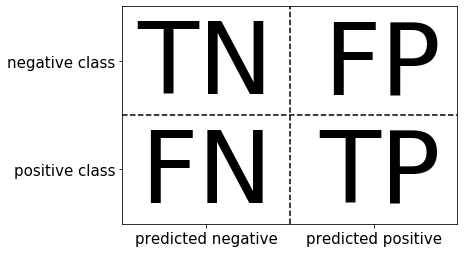

In [75]:
import mglearn

mglearn.plots.plot_binary_confusion_matrix()

In [125]:
confusion_matrix_1 = metrics.confusion_matrix(y_test, p)
confusion_matrix_1

array([[231,  43],
       [ 62, 110]])

In 119 cases, the classifier predicted correctly that the passenger survived. In 225 cases, the classifier predicted correctly that the passenger did not survive. In 52 cases, the classifier predicted wrongly that the passenger died in the Titanic and, in 50 cases, the classifier predicted wrongly that the passenger survived the sinking ship. 

#### Metrics: Recall

In [79]:
print(metrics.recall_score(y_test, p))

0.6944444444444444


#### Metrics: Precision

In [80]:
print(metrics.precision_score(y_test, p))

0.8012820512820513


#### Metrics: F1 Score


In [81]:
print(metrics.f1_score(y_test, p))

0.7440476190476191


#### Metrics: Kappa

In [82]:
print(metrics.cohen_kappa_score(y_test, p))

0.5906335382513661


## Sensitivity vs. Specificity

<a id='sens'></a>

(array([154.,  59.,  30.,  40.,  10.,   5.,  27.,  33.,  32.,  56.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

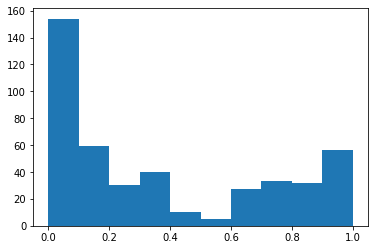

In [134]:
P_prob = model.predict_proba(X_test)[:,1]

plt.hist(P_prob)

In [135]:
from sklearn.preprocessing import binarize
p = binarize([P_prob], 0.95)[0]

In [136]:
confusion_matrix_2 = metrics.confusion_matrix(y_test, p)
confusion_matrix_2 

array([[270,   4],
       [128,  44]])

In [137]:
print('Precision score:', metrics.precision_score(y_test, p))
print('Recall score:', metrics.recall_score(y_test, p))
print('F1 score:', metrics.f1_score(y_test, p))

Precision score: 0.9166666666666666
Recall score: 0.2558139534883721
F1 score: 0.4


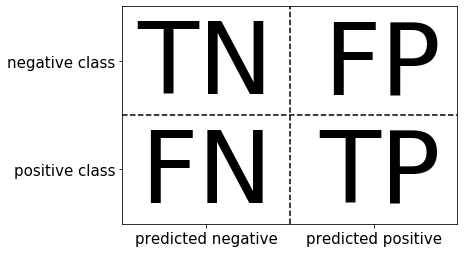

In [138]:
mglearn.plots.plot_binary_confusion_matrix()

In [132]:
confusion_matrix_1, confusion_matrix_2

(array([[231,  43],
        [ 62, 110]]),
 array([[270,   4],
        [128,  44]]))

When we change the sensitivity when classifying, there is a big change in the false positives (people who died but the model predicted the opposite). There is also an increase in the false-negative (people who survived but the model predicted the opposite). 

### ROC Curves

<a id='roc'></a>

Text(0, 0.5, 'sensitivity')

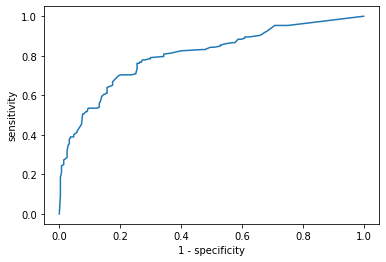

In [145]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, P_prob)

plt.plot(fpr, tpr);
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')

In [151]:
p_after_roc = binarize([P_prob], 0.62)[0]

metrics.confusion_matrix(y_test, p_after_roc)

array([[234,  40],
       [ 68, 104]])

In [152]:
print(metrics.roc_auc_score(y_test, p))

0.6206077066711934


## Testing Different Variables

<a id='newvar'></a>

##### Passenger Class

In [84]:
# Random Forest with Cross-validation 

variables = ['Gender_Bi', 'Fare', 'Pclass']

X = train[variables]
y = train['Survived']

X = X.fillna(-1)

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        prediction = model.predict(X_valid)

        acc = np.mean(y_valid == prediction)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.8193133583021222
Standard Deviation: 0.016888395892075966
Variance: 0.0002852179158074884


In [86]:
# Random Forest without Cross-validation

variables = ['Gender_Bi', 'Fare', 'Pclass']

X = train[variables]
y = train['Survived']

# Create train and valid variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

# Predict

p_pclass = model.predict(X_test)


# Confusion Matrix

metrics.confusion_matrix(y_test, p_pclass)



array([[241,  27],
       [ 69, 109]])

##### Age

In [89]:
# Random Forest with Cross-validation 

variables = ['Gender_Bi', 'Fare', 'Age']

X = train[variables]
y = train['Survived']

X = X.fillna(-1)

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        prediction = model.predict(X_valid)

        acc = np.mean(y_valid == prediction)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.7834082397003743
Standard Deviation: 0.017891531205037586
Variance: 0.0003201068888608337


In [92]:
# Random Forest without Cross-validation

variables = ['Gender_Bi', 'Fare', 'Age']

X = train[variables]
y = train['Survived']

# Create train and valid variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

# Predict

p_age = model.predict(X_test)


# Confusion Matrix

metrics.confusion_matrix(y_test, p_age)


array([[231,  43],
       [ 52, 120]])

##### Title 

In [91]:
# Random Forest with Cross-validation 

variables = ['Gender_Bi', 'Age', 'Title']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        prediction = model.predict(X_valid)

        acc = np.mean(y_valid == prediction)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))

Mean: 0.7665792759051184
Standard Deviation: 0.028982303376685264
Variance: 0.000839973909018222


In [93]:
# Random Forest without Cross-validation

variables = ['Gender_Bi', 'Age', 'Title']

X = train[variables]
y = train['Survived']

# Create train and valid variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

# Predict

p_title = model.predict(X_test)


# Confusion Matrix

metrics.confusion_matrix(y_test, p_title)



array([[204,  60],
       [ 70, 112]])

## Dimensionality Reduction Using Feature Selection

### Thresholding Numerical Feature Variance

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [153]:
# Define features and target

variables = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Title']

X = train[variables]
y = train['Survived']

In [154]:
# Create thresholder

thresholder = VarianceThreshold(threshold=.9)

In [155]:
# Create high variance feature matrix

features_high_variance = thresholder.fit_transform(X)

In [156]:
# View high variance feature matrix

features_high_variance[0:3]

array([[ 7.25  , 22.    ,  1.    ],
       [71.2833, 38.    ,  1.    ],
       [ 7.925 , 26.    ,  0.    ]])

In [157]:
# View variances 

thresholder.fit(X).variances_

array([2.46666531e+03, 6.98230591e-01, 3.09274323e+02, 1.21467827e+00,
       6.48999031e-01, 4.43441775e-01])

##### Pclass and Parch

The result using the two features with the highest variance was worse than the result using other variables. This might be explained by the fact that the other variables, despite having lower variances, are actually extreme powerfull in explaining the target variable. 


In [119]:
# Random Forest with Cross-validation 

variables = ['Pclass', 'Parch']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p3 = model.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))



Mean: 0.7092883895131087
Standard Deviation: 0.040195415434580425
Variance: 0.0016156714219585063


## SVM - Support Vector Machines
Maximizes the distance to the nearest point = margin 

In [39]:
# Linear SVM with Cross-validation 

from sklearn.svm import SVC

variables = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Title']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        clf = SVC(kernel='linear')
        clf.fit(X_train, y_train)

        p3 = clf.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))


Mean: 0.7058926342072411
Standard Deviation: 0.04709823827779012
Variance: 0.002218244048871494


#### Results with different kernels
**Linear:** 0.7058
**Poly:** 0.6442
**Rbf:** 0.6823
**Sigmoid:** 0.5589


In [44]:
# SVM with Cross-validation, and different kernels 

# Kernels to be used: linear, poly, rbf, sigmoid, precomputed or a callable. 

from sklearn.svm import SVC

variables = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Title']

X = train[variables]
y = train['Survived']

results = []

for rep in range(10):

    kf = KFold(10, shuffle=True, random_state = 0)

    for train_lines, valid_lines in kf.split(X):
        X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
        y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

        clf = SVC(kernel='sigmoid')
        clf.fit(X_train, y_train)

        p3 = clf.predict(X_valid)

        acc = np.mean(y_valid == p3)
        results.append(acc)

# Results measures         
        
print('Mean:', np.mean(results))
print('Standard Deviation:', np.std(results))
print('Variance:', np.var(results))


Mean: 0.5589388264669163
Standard Deviation: 0.04532672408507392
Variance: 0.00205451191628442


### A Regression Approach

Null Hypothesis - Age, P-class, Gender_Bi, Title, and, Fare are not related to surviving the sinking.

Alternative Hypotheses - They influence in surviving the sinking. 

In [8]:
train_reg = train.copy()

train_reg.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,2


In [9]:
# Add intercept column

train_reg['intercept'] = 1
train_reg.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender_Bi,Title,intercept
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,2,1


In [14]:
# Use statsmodels to import regression model. Instantiate the model, and fit the model. 

import statsmodels.api as sm
import statsmodels

log_mod = sm.Logit(train_reg['Survived'], train_reg[['intercept', 'Age', 'Pclass', 'Gender_Bi', 'Title', 'Fare']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.455218
         Iterations 6


In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Fri, 29 May 2020   Pseudo R-squ.:                  0.3164
Time:                        16:27:45   Log-Likelihood:                -405.60
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 5.765e-79
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4983      0.481      1.035      0.300      -0.445       1.442
Age           -0.0168      0.005     -3.125      0.002      -0.027      -0.006
Pclass        -1.0732      0.134     -7.994      0.000      -1.336      -0.810
Gender_Bi      2.9037      0.219     13.236      0.000       2.474       3.334
Title          0.3646      0.140      2.600      0.009       0.090       0.639
Fare           0.0010      0.002      0.489      0.625      -0.003       0.005
==============================================================================
"""


The only variable that seems to not influence surviving the sinking is the Fare. Since the p-value is large, we have enough evidence to reject the null hypothesis. 